# Modeling the Daily Rat Sightings by Borough

In [40]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Patch
import datetime
import random

In [41]:
df = pd.read_csv("../scr/data/cleaned_rat_sightings_data/daily_borough_rs.csv")

RMSE=[]

df.head(9)

created_date        borough  count
0   2020-01-01          BRONX      3
1   2020-01-01       BROOKLYN      7
2   2020-01-01      MANHATTAN      4
3   2020-01-01         QUEENS      2
4   2020-01-01  STATEN ISLAND      1
5   2020-01-02          BRONX      7
6   2020-01-02       BROOKLYN     21
7   2020-01-02      MANHATTAN      7
8   2020-01-02         QUEENS      4

In [63]:
cut_off = '2025-06-01'
before_cut_off = '2025-05-31'
last_day = '2025-09-30'

## Simplifications

For now, we focus solely on Manhattan. First, let us recall the baseline model.

## Baseline

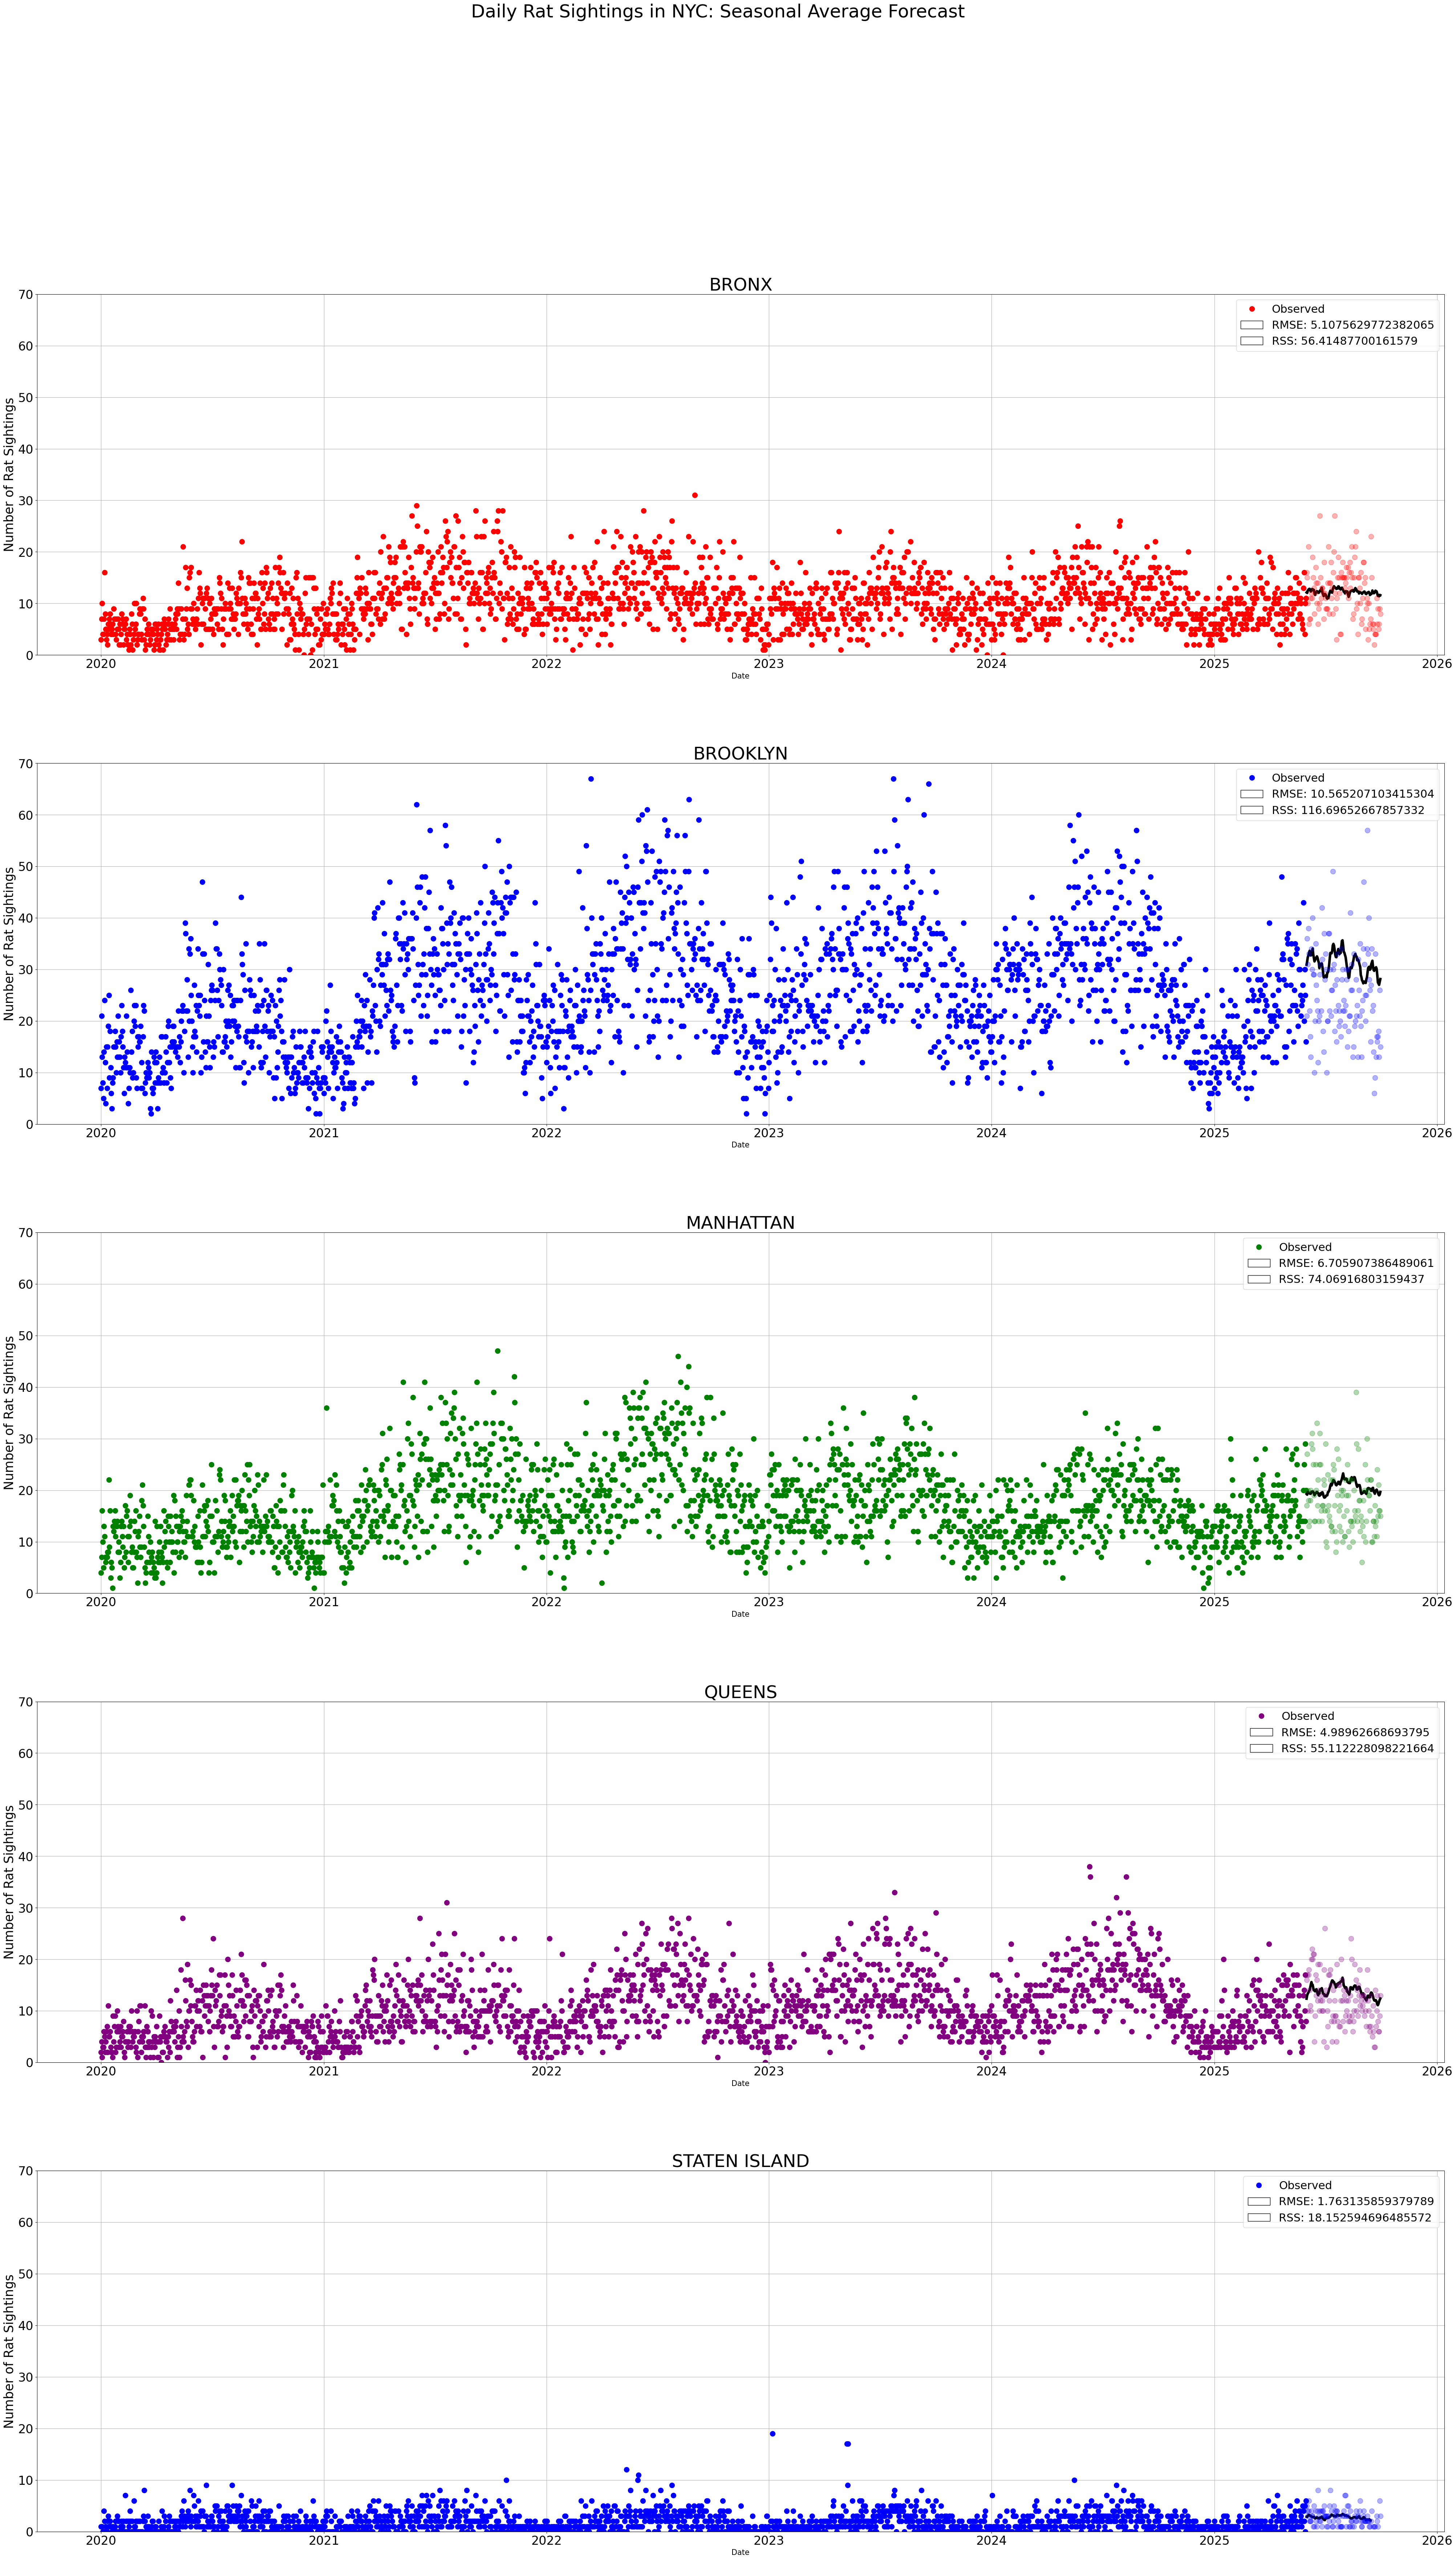

In [64]:
cdate_borough_test = df[df['created_date']>=cut_off]
cdate_borough_test = cdate_borough_test[cdate_borough_test['created_date']<=last_day]

cdate_borough = df[df['created_date']<cut_off]
cdate_borough = cdate_borough[cdate_borough['created_date']>='2020-01-01']


boroughs = [b for b in df['borough'].unique() if pd.notnull(b) and b != 'Unspecified']


def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
    df = data.copy()
    df["created_date"] = pd.to_datetime(df["created_date"])
    df["doy"] = df["created_date"].dt.dayofyear
    df["year"] = df["created_date"].dt.year

    forecasts = []
    for target_date in target_dates:
        target_doy = target_date.dayofyear
        target_year = target_date.year
        mask = (
            (df["year"] >= target_year - years_back) &
            (df["year"] < target_year) &
            (np.abs(df["doy"] - target_doy) <= day_window)
        )

        forecasts.append(df.loc[mask, "count"].mean())

    return pd.Series(forecasts, index=target_dates)


# ensure global dataframe is datetime
cdate_borough["created_date"] = pd.to_datetime(cdate_borough["created_date"])


fig = plt.figure(figsize=(50,80))
gs = gridspec.GridSpec(5,1, figure=fig, wspace=0.3, hspace=0.3)

colors = ["r", "b", "g", "purple", "b"]

for i, borough in enumerate(boroughs):
    ax = fig.add_subplot(gs[i])

    borough_data = cdate_borough[cdate_borough["borough"] == borough].assign(created_date=lambda df: pd.to_datetime(df["created_date"])).sort_values("created_date").set_index("created_date")

    # create a complete daily date range
    full_range = pd.date_range(start="2020-01-01", end=before_cut_off, freq="D")

    # reindex and fill missing days with 0
    borough_data = borough_data.reindex(full_range).assign(count=lambda df: df["count"].fillna(0),borough=borough).rename_axis("created_date").reset_index()

    borough_data_test = cdate_borough_test[cdate_borough_test["borough"] == borough].sort_values("created_date").copy()
        
    last_date = cdate_borough["created_date"].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(borough_data_test), freq="D")
    
    # compute seasonal-average forecast
    forecast = seasonal_average_forecast(borough_data,future_dates,years_back=5)

    # plot observed data
    ax.plot(borough_data["created_date"].dt.to_pydatetime(), borough_data["count"], "o", color=colors[i], markersize=10, label="Observed")

    # plot forecast
    ax.plot(forecast.index, forecast.values, color="black", linewidth=5, linestyle = "-", label="Seasonal Avg Forecast")

    borough_data_test["created_date"] = pd.to_datetime(borough_data_test["created_date"])
    ax.plot(borough_data_test["created_date"], borough_data_test["count"], "o", color=colors[i], markersize=10, alpha=0.3, label="Observed")

    actual_series = borough_data_test.set_index('created_date')['count']
    actual_aligned = actual_series.reindex(forecast.index, fill_value=0)

    rmse = np.sqrt(np.mean((actual_aligned - forecast.values)**2))
    rss = np.sqrt(np.sum((actual_aligned - forecast.values)**2))

    ax.set_title(f"{borough}", fontsize=35)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Number of Rat Sightings", fontsize=25)
    ax.grid(True)
    ax.set_ylim(0,70)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse}')
    text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss}')
    ax.legend(handles=[ax.lines[0], text_box, text_box2], fontsize=22)
    if borough == 'MANHATTAN':
        RMSE.append(rmse)
        
    
    

plt.suptitle("Daily Rat Sightings in NYC: Seasonal Average Forecast", fontsize=36)
plt.show()





## SARIMA on MANHATTAN

We try to model the number of daily rat sightings in Manhattan. We wish to beat the RMSE there.

In [65]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [66]:
rs = df[df['borough']=='MANHATTAN']

rs['created_date'] = pd.to_datetime(rs['created_date']) 

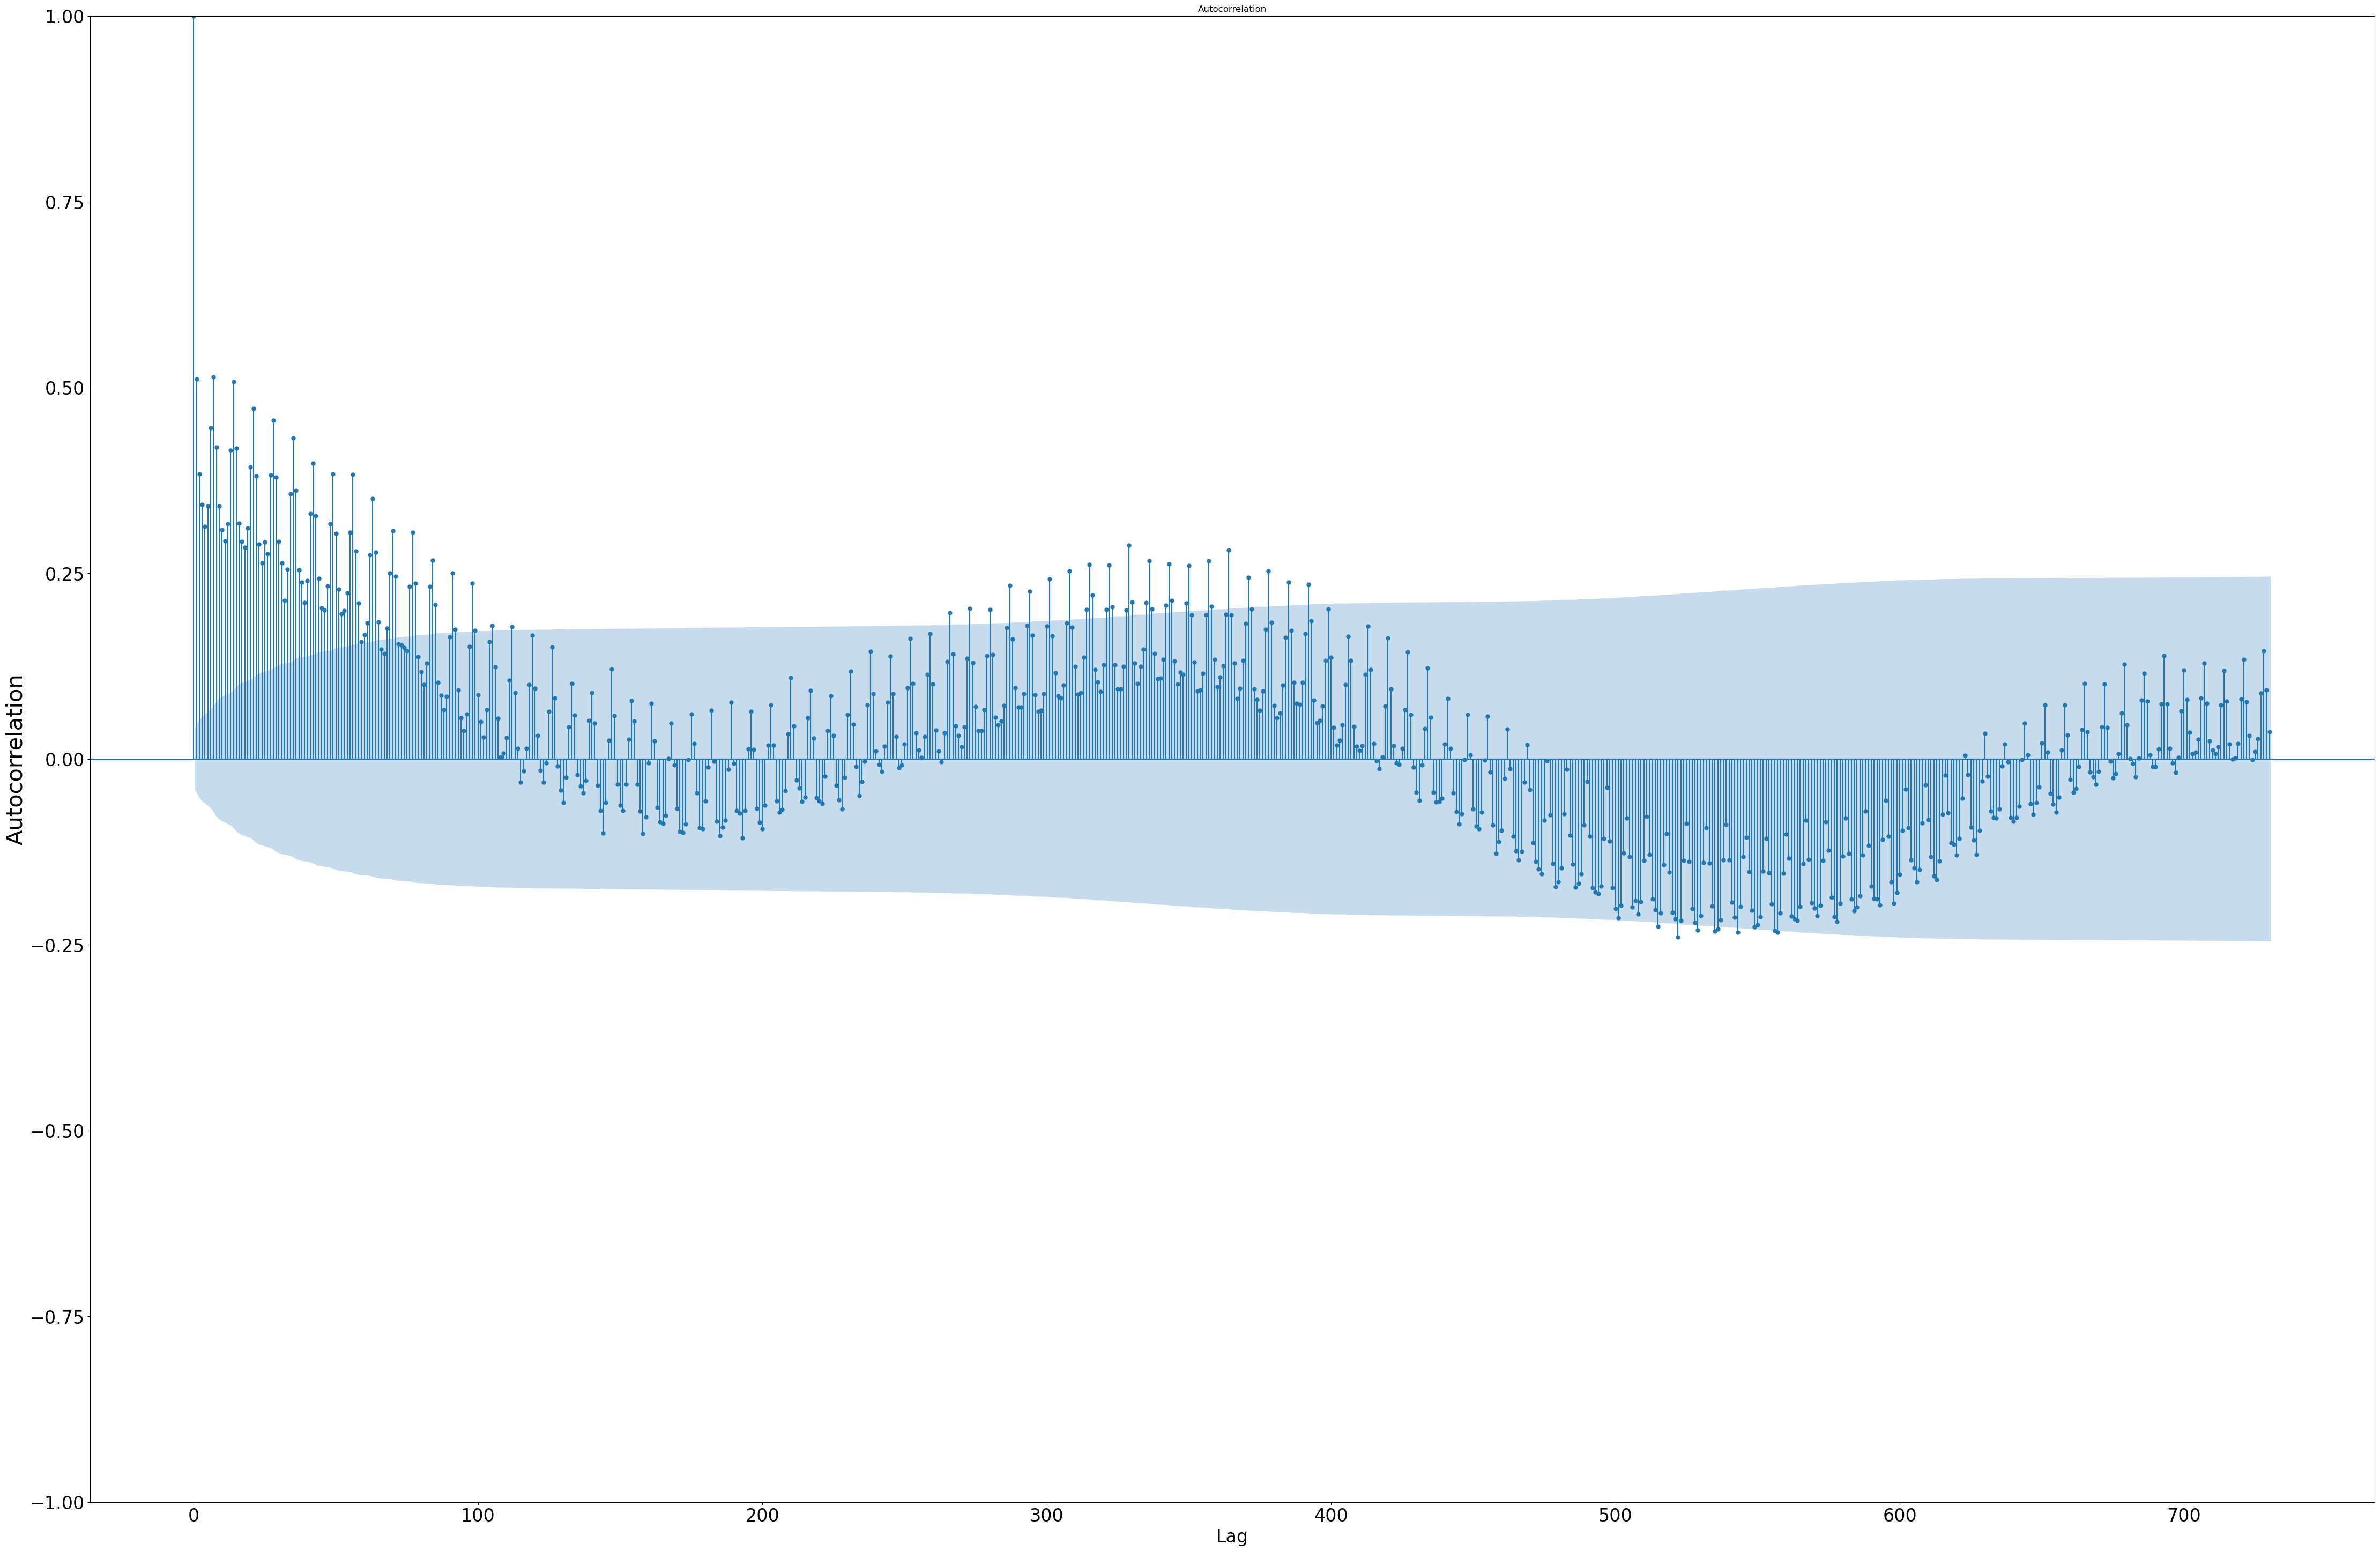

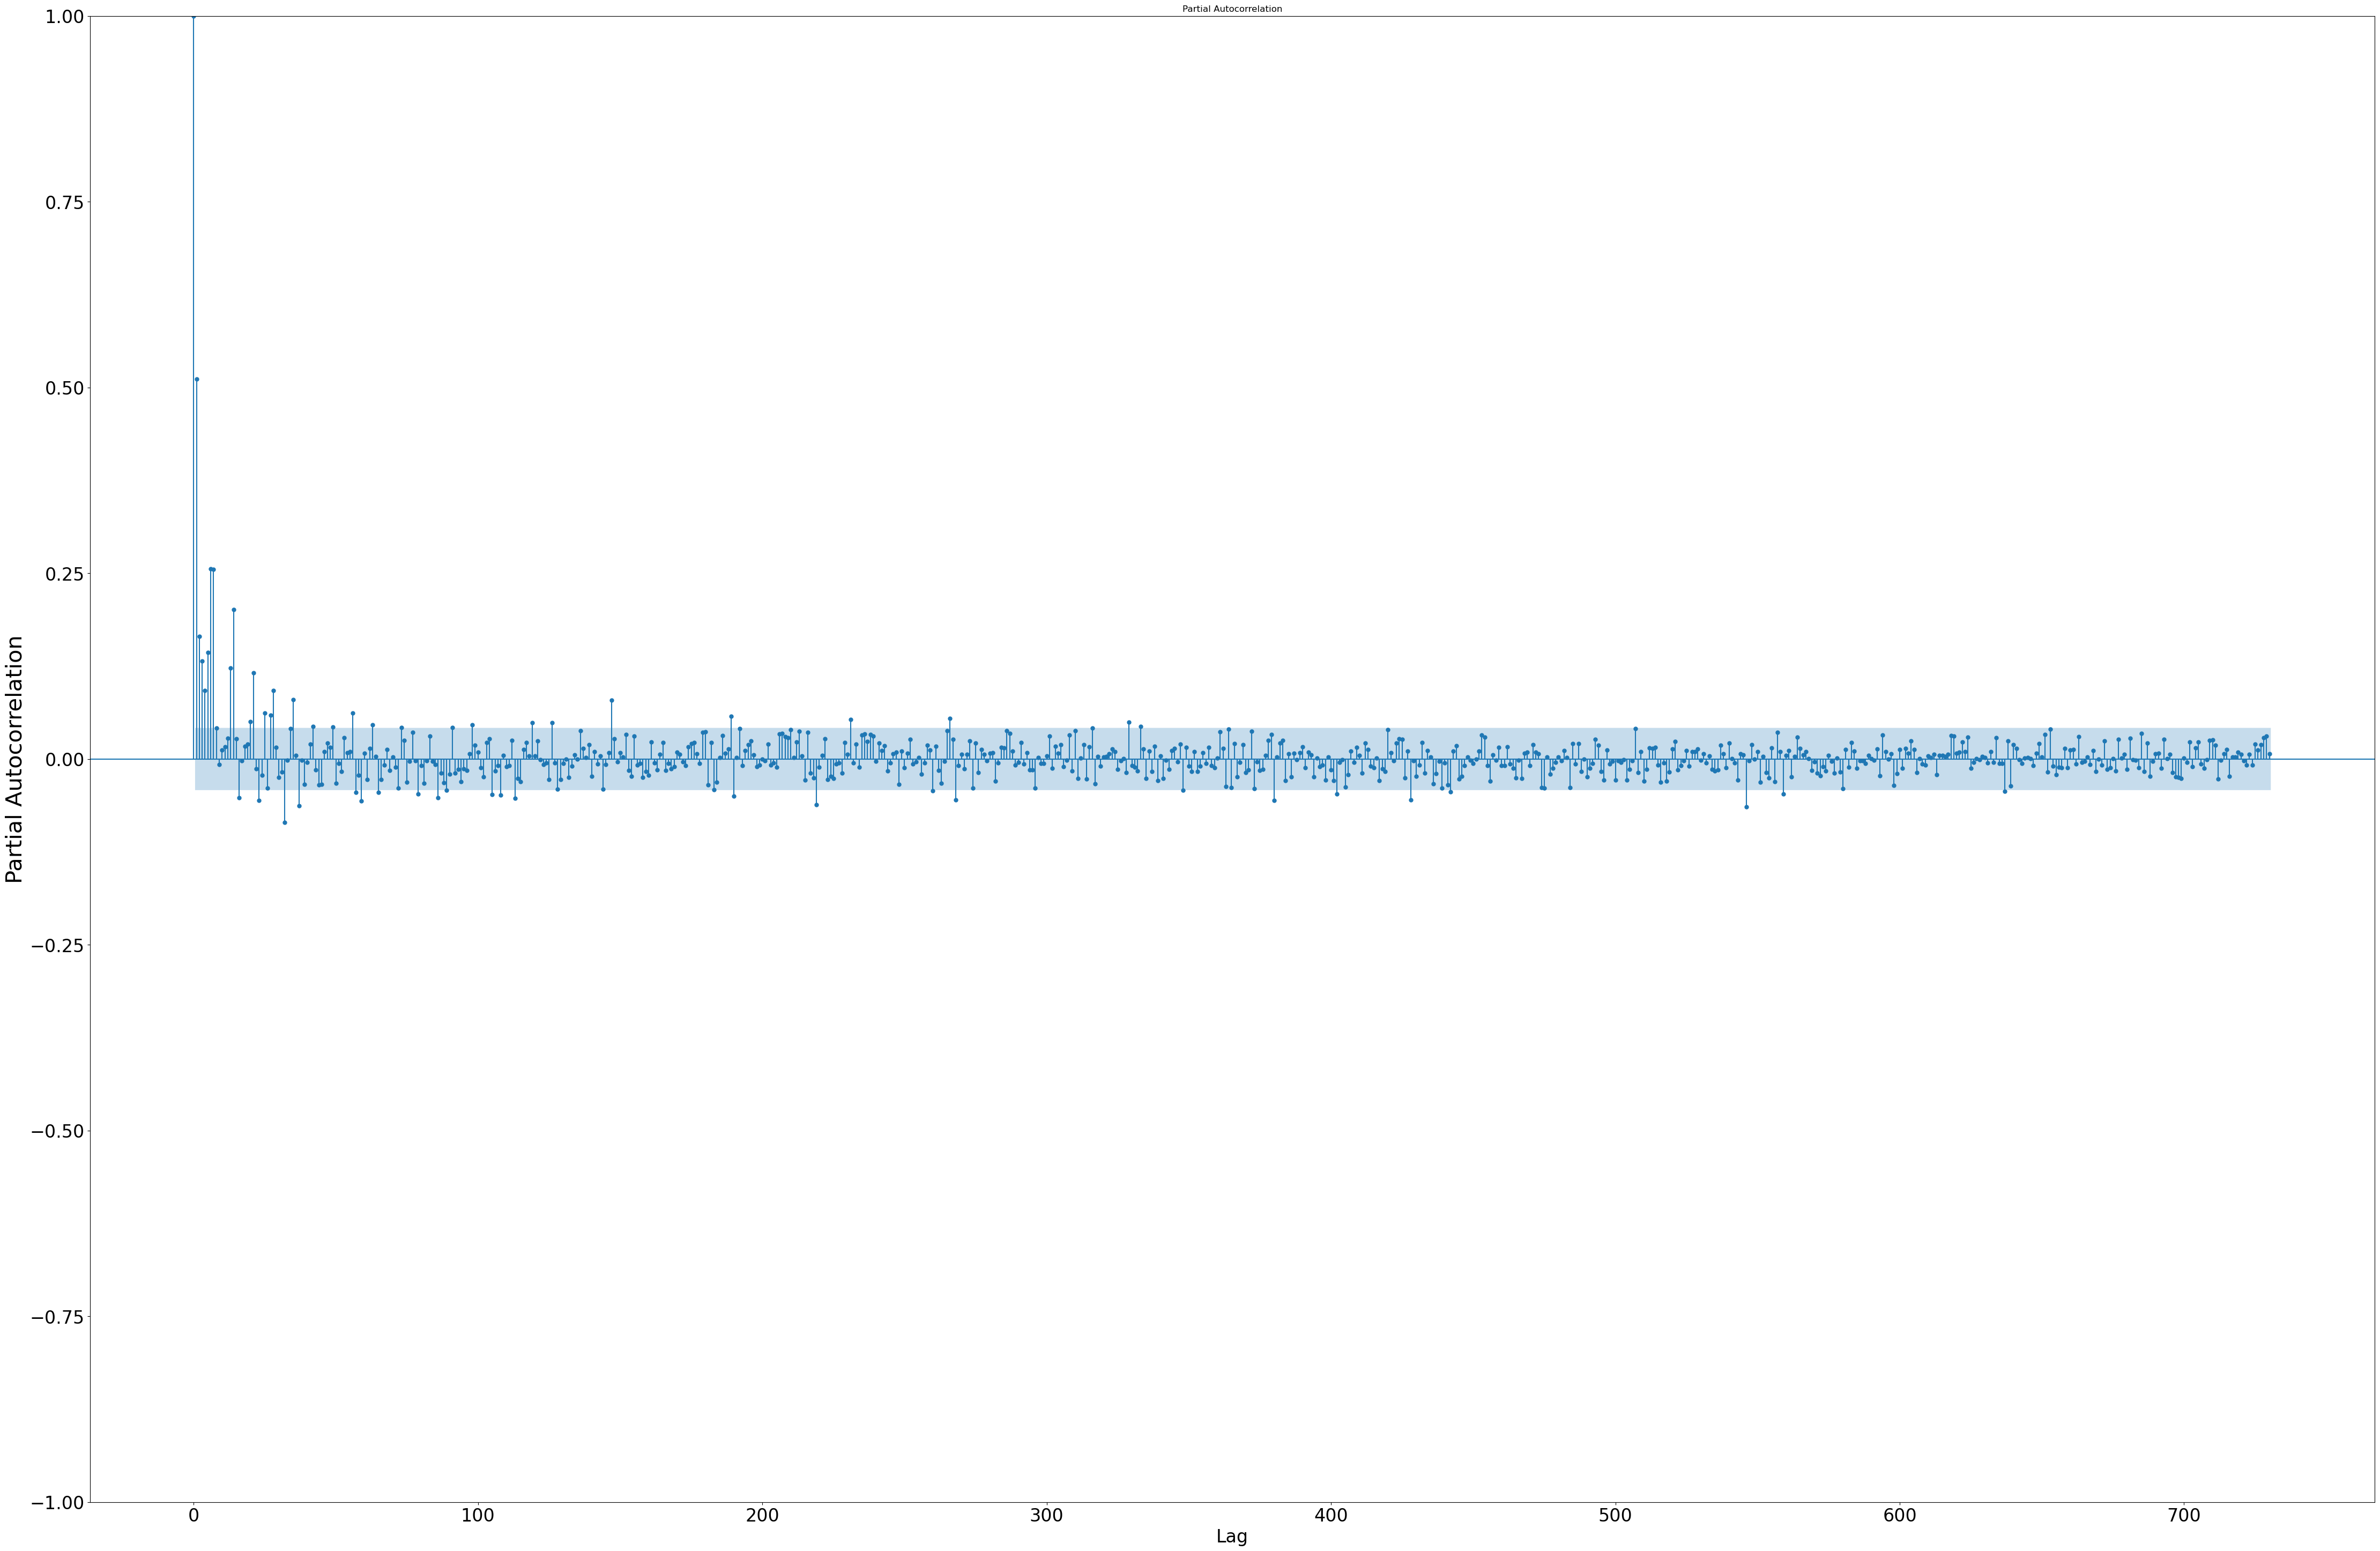

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(55,36))
sm.graphics.tsa.plot_acf(rs['count'], lags = 365*2, ax=ax)
plt.xlabel("Lag",fontsize=24)
plt.ylabel("Autocorrelation",fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(55,36))
sm.graphics.tsa.plot_pacf(rs['count'], lags = 365*2, ax=ax)
plt.xlabel("Lag",fontsize=24)
plt.ylabel("Partial Autocorrelation",fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [68]:
import statsmodels.tsa.api as sm
from pmdarima import auto_arima

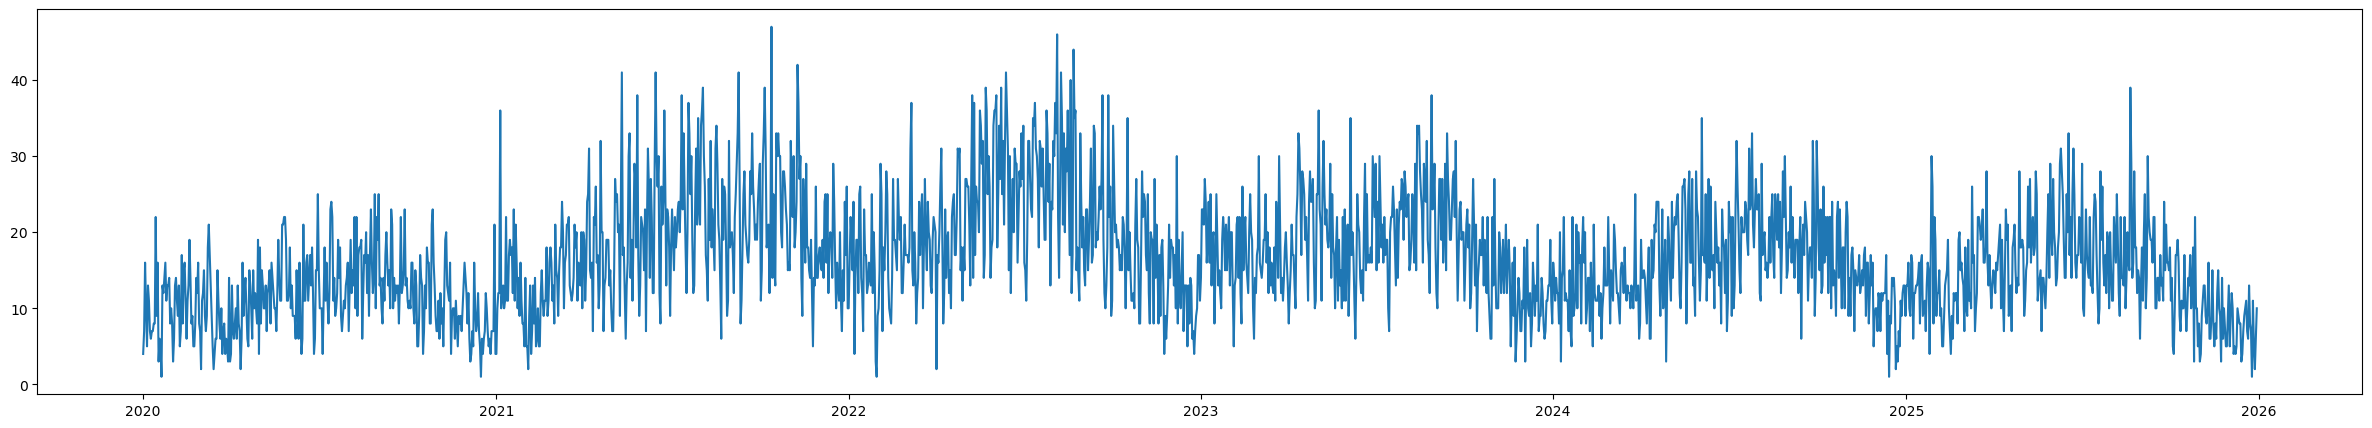

In [69]:
y = rs
plt.figure(figsize=(30,5))
plt.plot(y['created_date'], y['count'])
plt.show()

In [70]:
y_train = y[y['created_date']< cut_off]
y_test = y[y['created_date']>= cut_off]

In [71]:
# A SARIMA model is not wise for seasonality of 1 year with daily data. Picking m = 7 is NOT appropriate here unless we 
# see seasonality with 7 day periods.
# See https://alkaline-ml.com/pmdarima/2.0.1/tips_and_tricks.html?highlight=seasonal


# Uncomment the line below to find AIC minimizing values to use for the ARIMA model. 
z = y_train['count'].to_numpy()
#auto_arima(z, trace=True, error_action="ignore", stepwise=True, seasonal=True, m = 30)

/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1978
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -6225.299
Date:                Thu, 26 Feb 2026   AIC                          12464.598
Time:                        16:15:22   BIC                          12503.724
Sample:                             0   HQIC                         12478.973
                               - 1978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2412      0.003    357.571      0.000       1.234       1.248
ar.L2         -0.9917      0.003   -286.047      0.000      -0.998      -0.985
ma.L1         -2.0446      0.022    -92.135      0.0

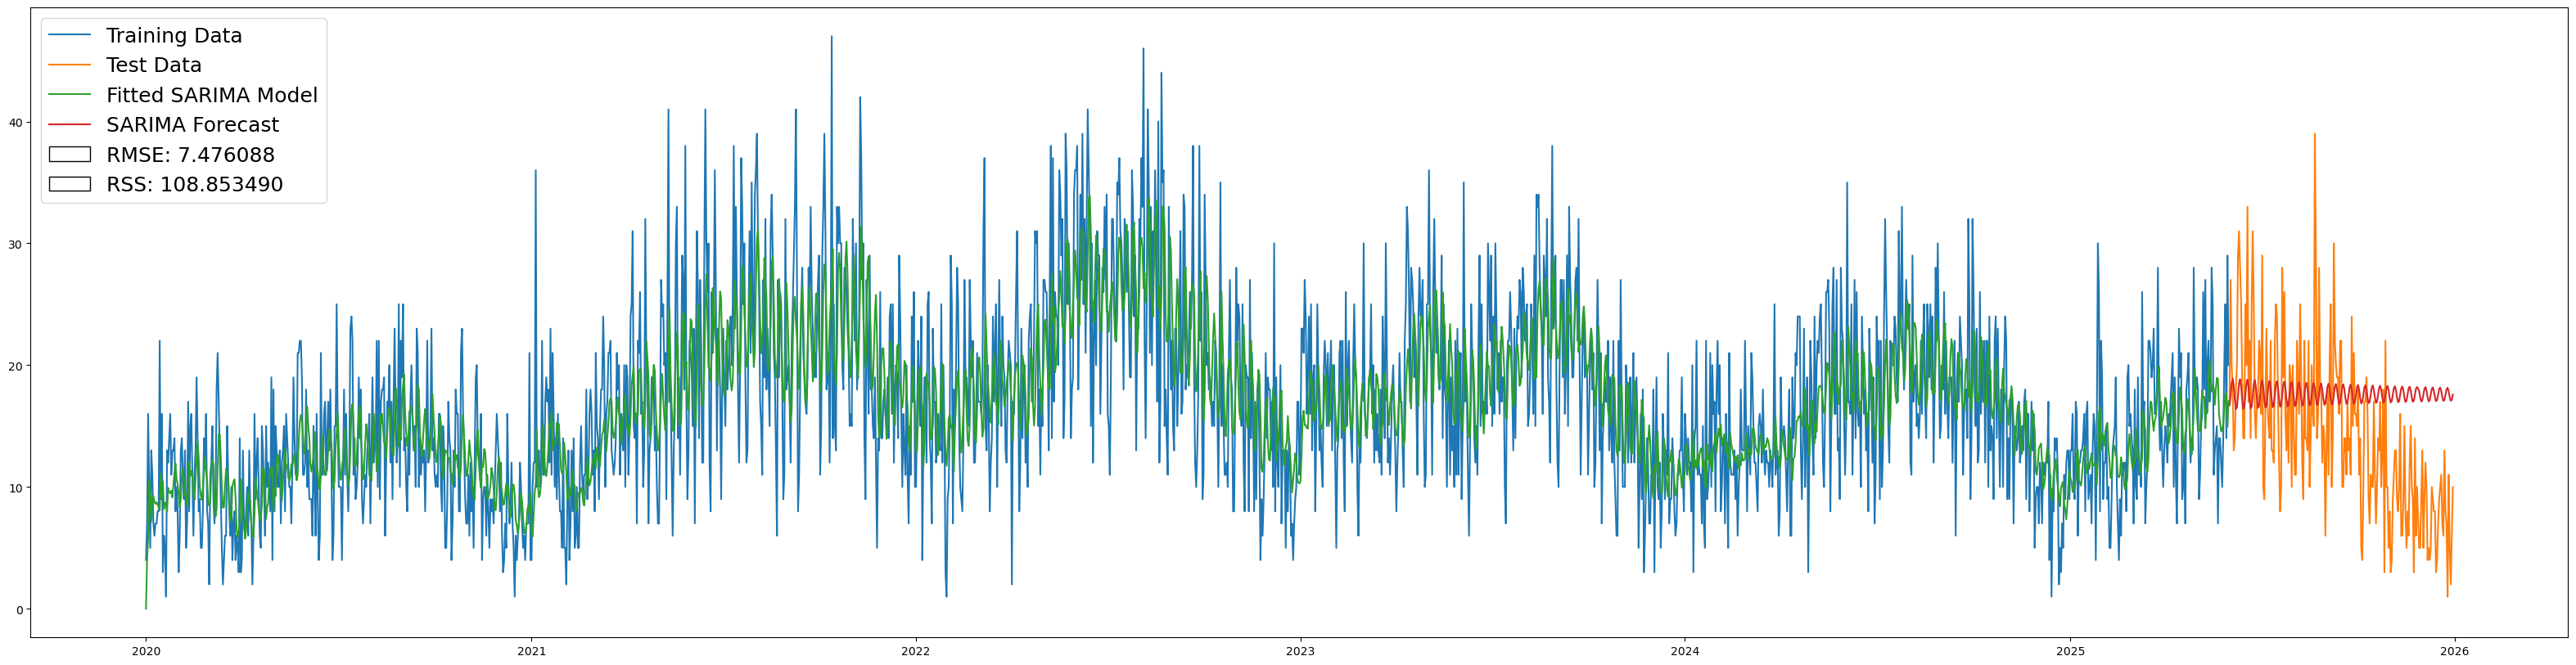

In [72]:
model = sm.ARIMA(z, order = (2, 1, 4), seasonal_order=(0,0,0,30)).fit()
print(model.summary())
plt.figure(figsize=(40,10))
plt.plot(y_train['created_date'], y_train['count'], label="Training Data")
plt.plot(y_test['created_date'], y_test['count'], label="Test Data")

plt.plot(y_train['created_date'], model.fittedvalues, label="Fitted SARIMA Model")
plt.plot(y_test['created_date'], model.forecast(len(y_test['created_date'])), label="SARIMA Forecast")


rmse = np.sqrt(np.mean((y_test['count'] - model.forecast(len(y_test['created_date'])))**2))

RMSE.append(rmse)

rss = np.sqrt(np.sum((y_test['count'] - model.forecast(len(y_test['created_date'])))**2))
text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse:.2f}')
text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss:.2f}')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([text_box, text_box2])
labels.extend([f"RMSE: {rmse:.6f}", f"RSS: {rss:.6f}"])

plt.legend(handles=handles, labels=labels, fontsize=18)
plt.show()

In [73]:
print(f"For Manhattan and forecast from {cut_off} until {last_day}.")
print(f"Improved from RMSE of {float(RMSE[0])} to {float(RMSE[1])}.\n")
print(f"This is a {round((1-(RMSE[1]/RMSE[0]))*100, 4)}% reduction.")

For Manhattan and forecast from 2025-06-01 until 2025-09-30.
Improved from RMSE of 6.705907386489061 to 7.476088359872861.

This is a -11.4851% reduction.


# Weekly Rat Sightings in MANHATTAN

In [85]:
weekly_borough_rs = pd.read_csv('../scr/data/cleaned_rat_sightings_data/weekly_borough_rs.csv')

# drop unspecified boroughs
weekly_borough_rs = weekly_borough_rs[weekly_borough_rs['borough'] != 'Unspecified']

weekly_borough_rs["week_start"] = pd.to_datetime(weekly_borough_rs["created_date"].str.split("/").str[0])

weekly_borough_rs = weekly_borough_rs[weekly_borough_rs["week_start"]<=last_day]

weekly_borough_rs

borough = 'MANHATTAN'
weekly_borough_rs = weekly_borough_rs[weekly_borough_rs['borough']==borough]


cut_off = "2025-09-01"

train = weekly_borough_rs[(weekly_borough_rs["week_start"] >= "2020-01-01") & (weekly_borough_rs["week_start"] < cut_off)]
test = weekly_borough_rs[(weekly_borough_rs["week_start"] >= cut_off) & (weekly_borough_rs["week_start"] <= last_day)]



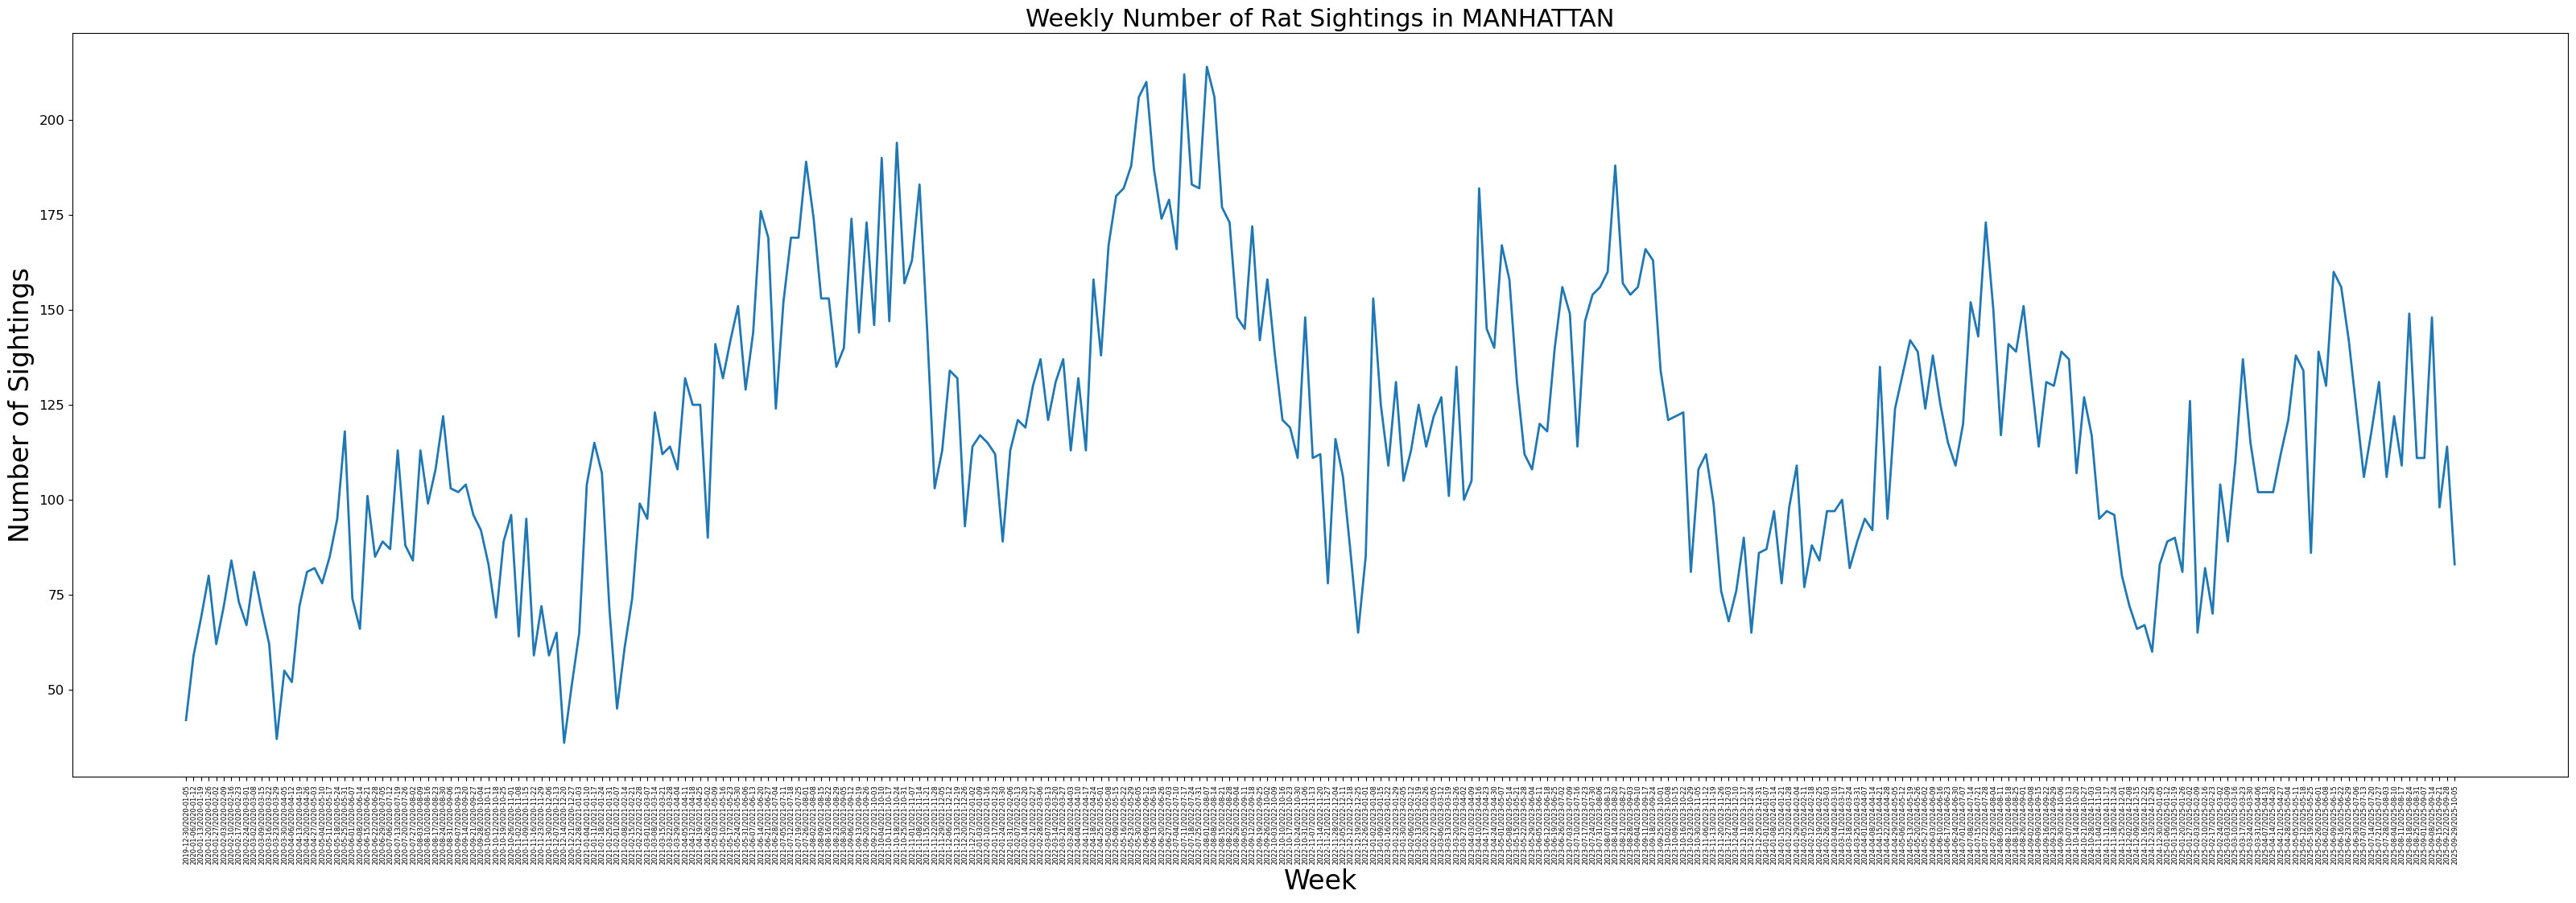

In [86]:
plt.figure(figsize=(40,12))
plt.plot(weekly_borough_rs['created_date'], weekly_borough_rs['count'],linewidth=2)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=12)
plt.title(f"Weekly Number of Rat Sightings in {borough}", fontsize=22)
plt.xlabel("Week", fontsize=24)
plt.ylabel("Number of Sightings", fontsize=24)
plt.show()

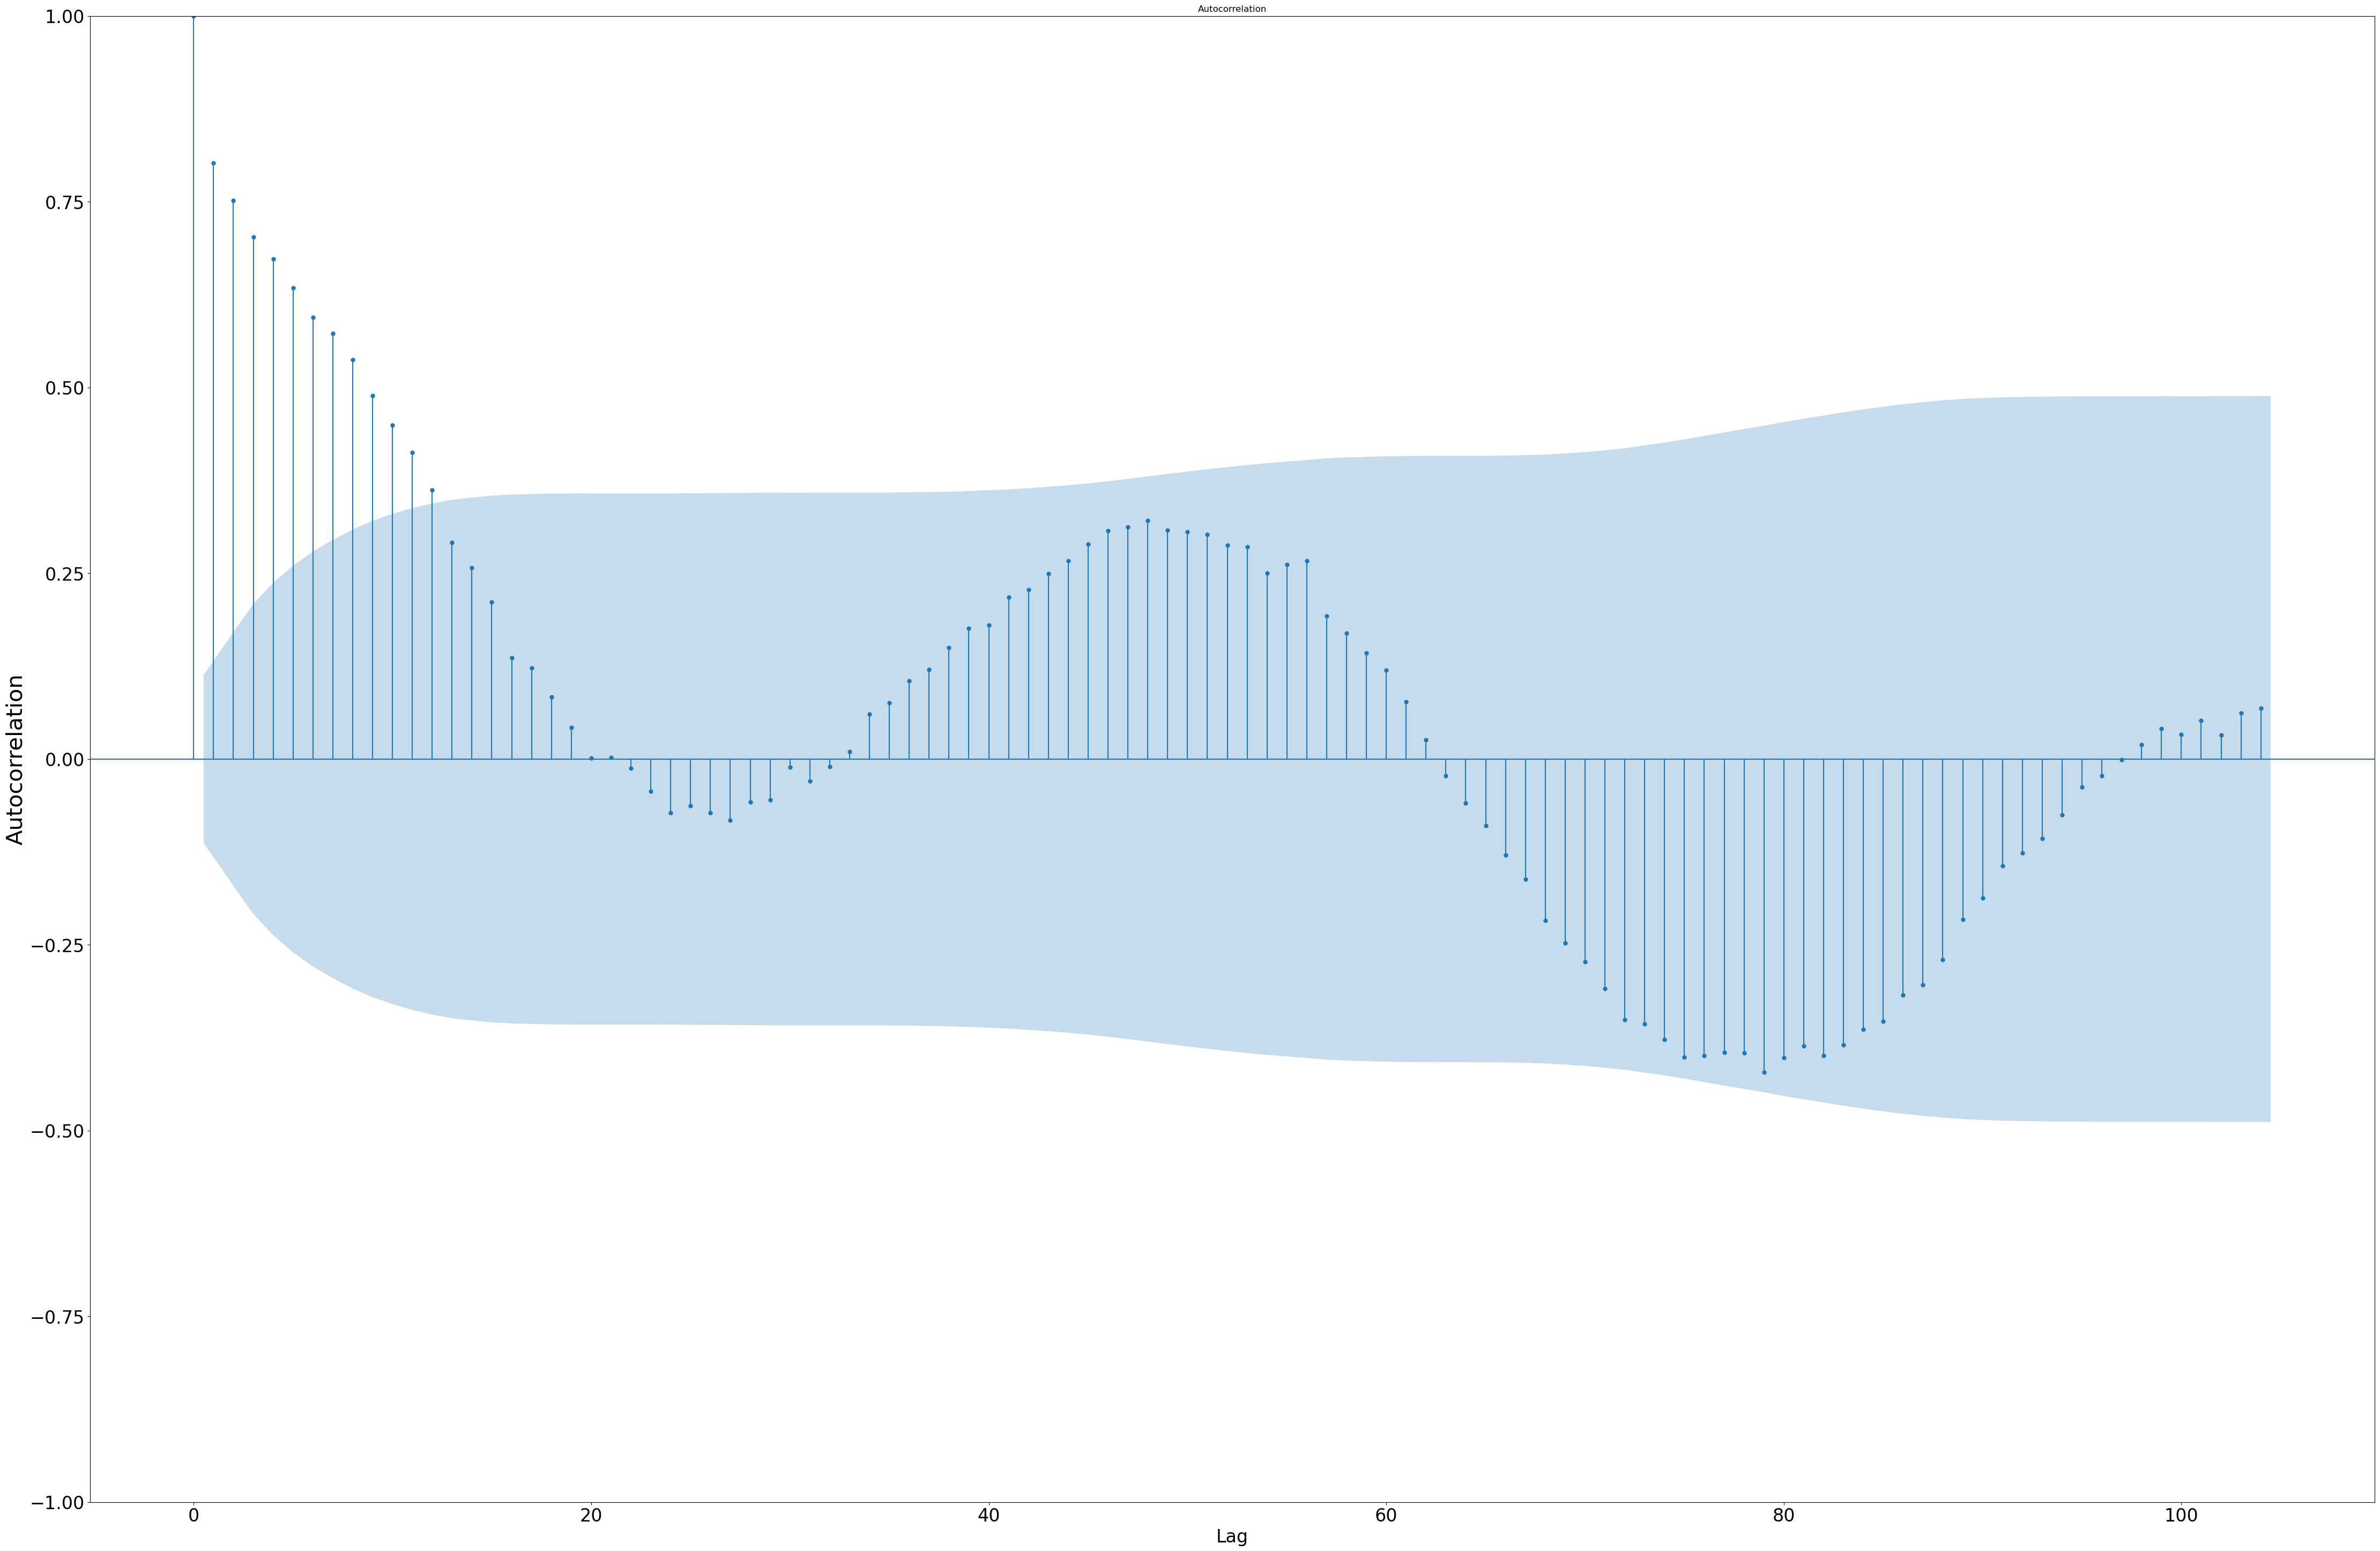

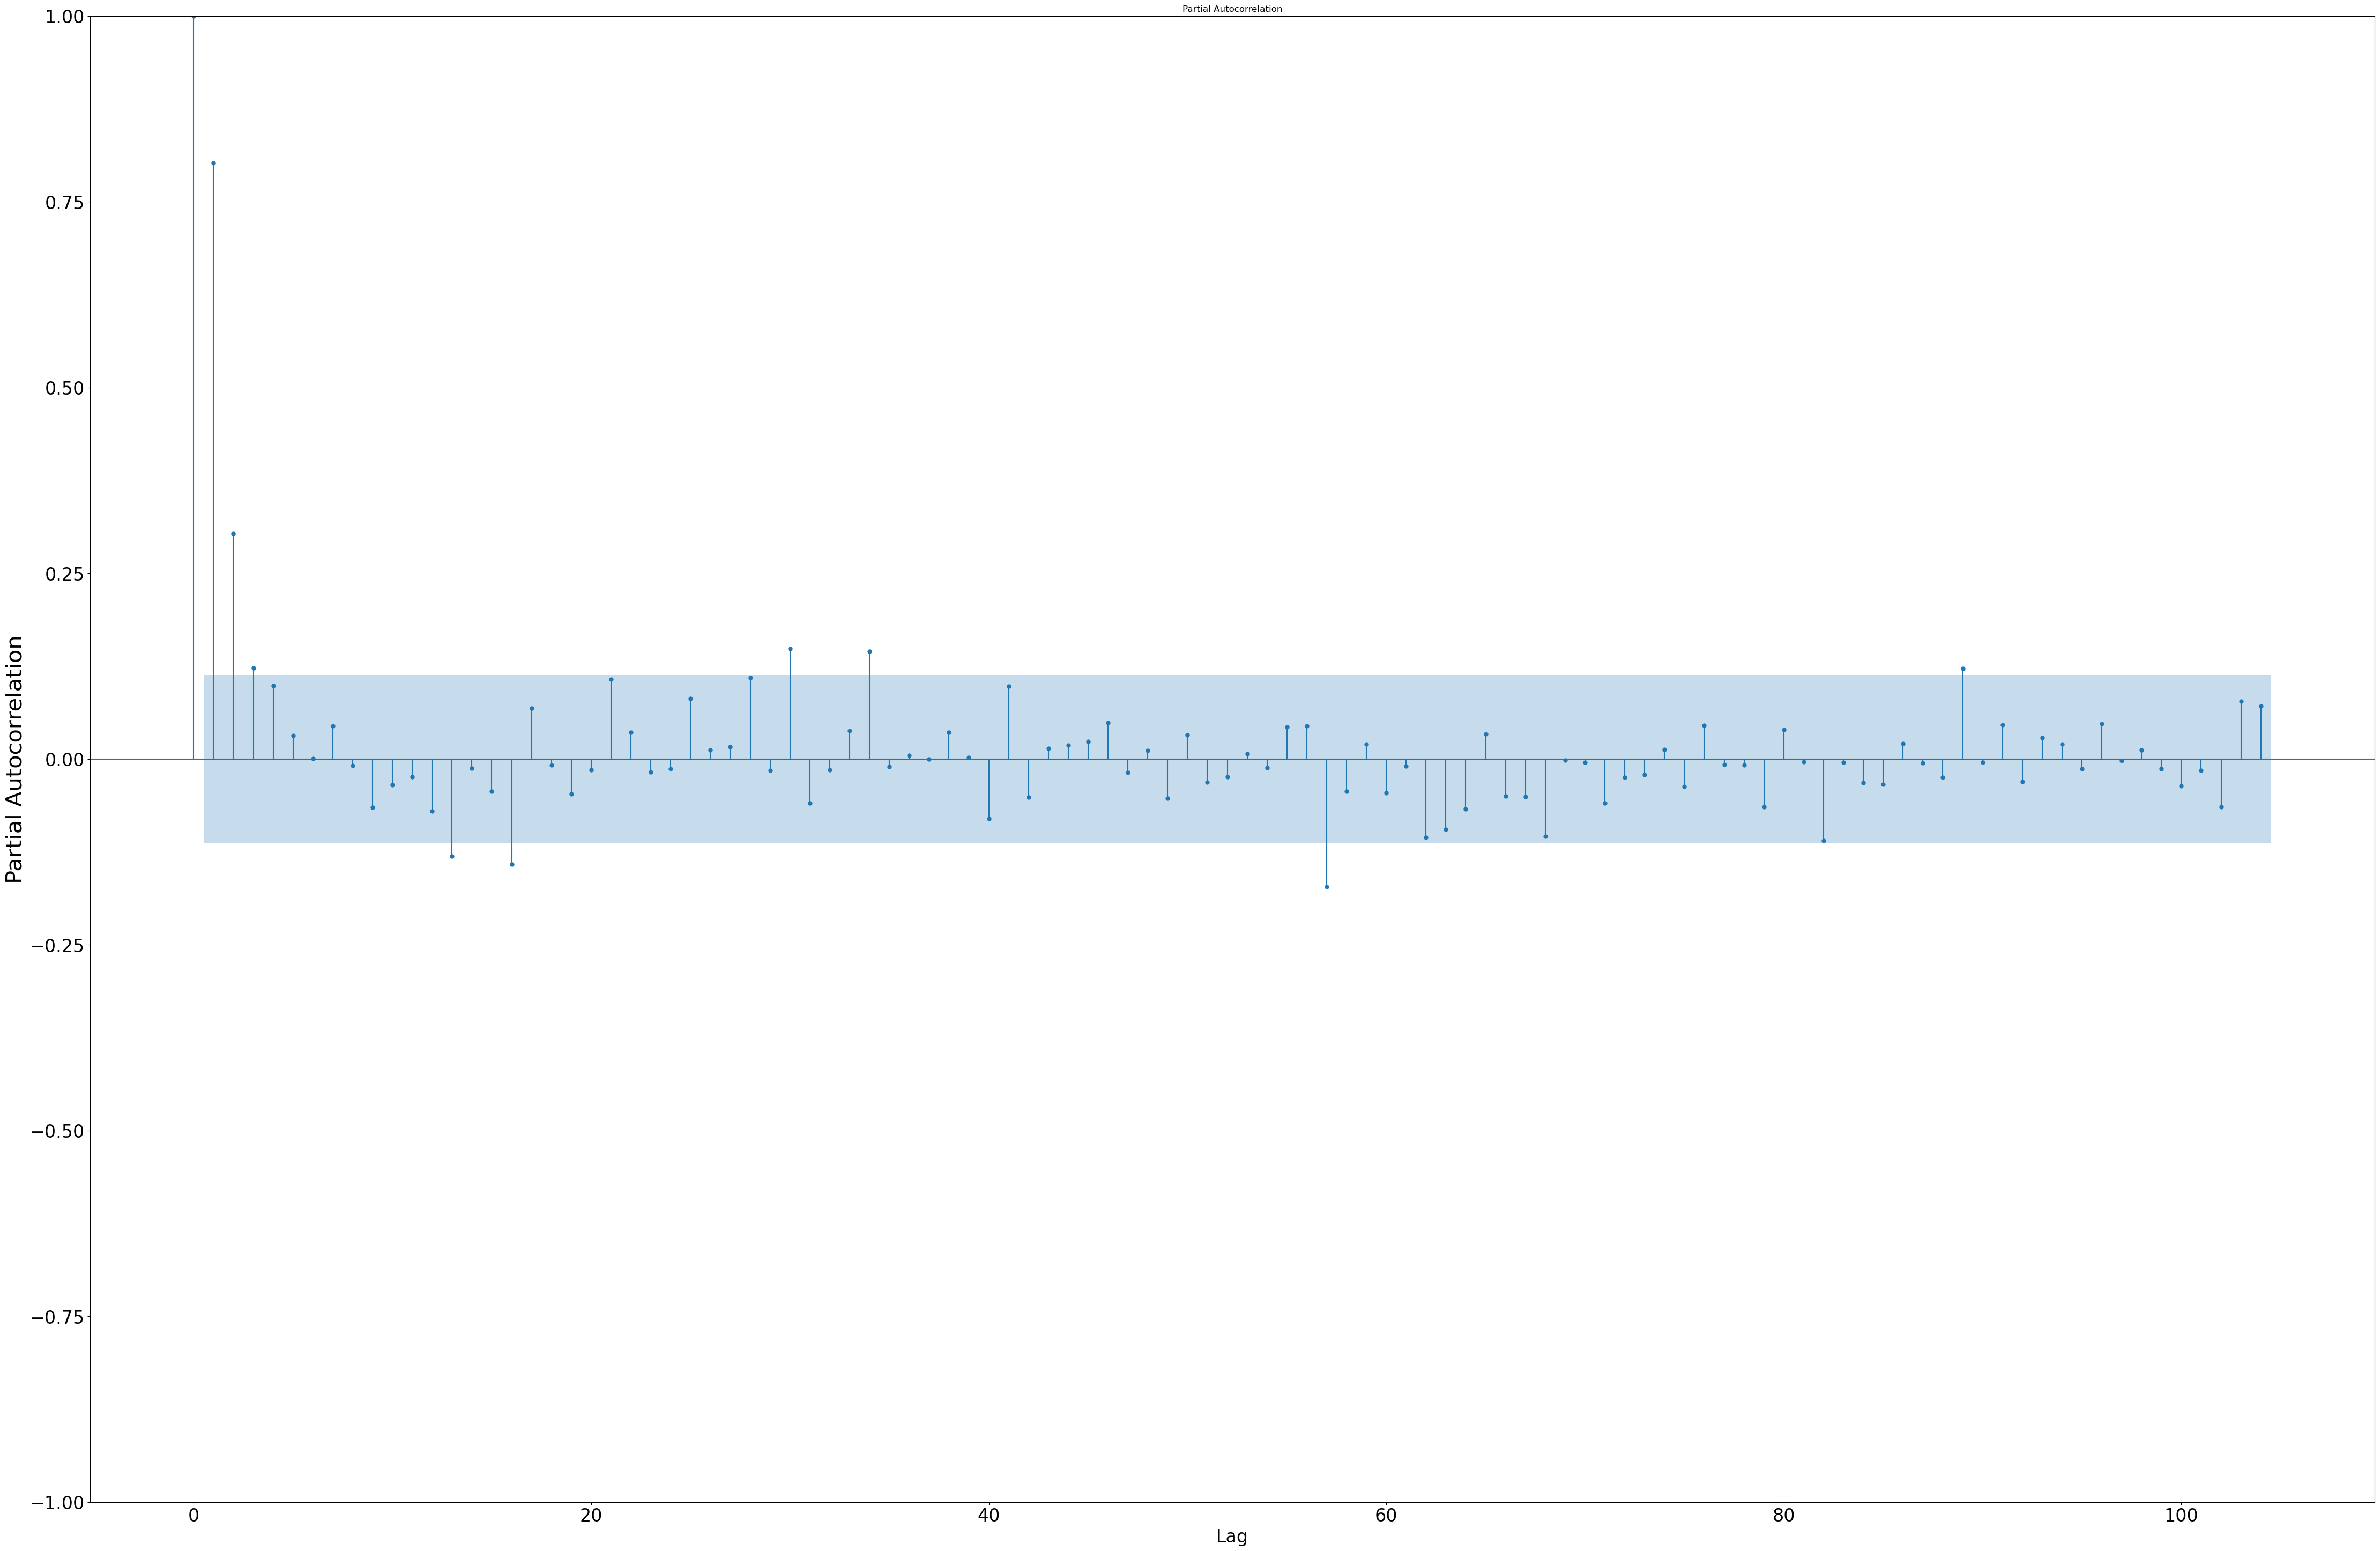

In [87]:
import statsmodels.api as sm

rs = weekly_borough_rs

fig, ax = plt.subplots(1, 1, figsize=(55,36))
sm.graphics.tsa.plot_acf(rs['count'], lags = 52*2, ax=ax)
plt.xlabel("Lag",fontsize=24)
plt.ylabel("Autocorrelation",fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(55,36))
sm.graphics.tsa.plot_pacf(rs['count'], lags = 52*2, ax=ax)
plt.xlabel("Lag",fontsize=24)
plt.ylabel("Partial Autocorrelation",fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [88]:
import statsmodels.tsa.api as sm
from pmdarima import auto_arima

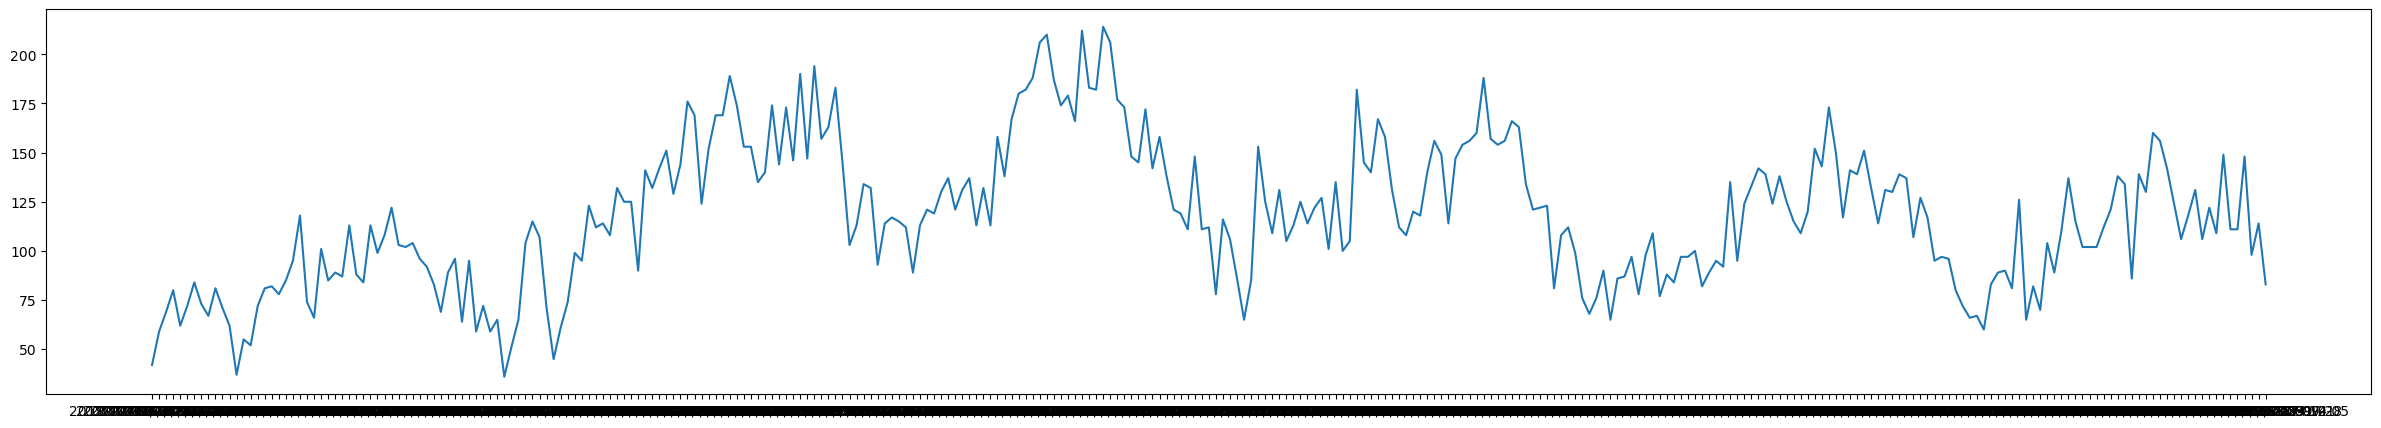

In [89]:
y = rs
plt.figure(figsize=(30,5))
plt.plot(y['created_date'], y['count'])
plt.show()

In [90]:
y_train = y[y['created_date']< cut_off]
y_test = y[y['created_date']>= cut_off]

In [91]:
# See https://alkaline-ml.com/pmdarima/2.0.1/tips_and_tricks.html?highlight=seasonal
# Uncomment the line below to find AIC minimizing values to use for the ARIMA model. 
z = y_train['count'].to_numpy()
auto_arima(z, trace=True, 
           #error_action="ignore", 
           stepwise=True, 
           seasonal=True, 
           m = 53)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[53] intercept   : AIC=inf, Time=4.34 sec
 ARIMA(0,1,0)(0,0,0)[53] intercept   : AIC=2659.919, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[53] intercept   : AIC=2619.027, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[53] intercept   : AIC=2604.467, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[53]             : AIC=2657.953, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[53] intercept   : AIC=2605.338, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[53] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,1,1)(0,0,2)[53] intercept   : AIC=2605.789, Time=4.81 sec
 ARIMA(0,1,1)(1,0,0)[53] intercept   : AIC=2604.213, Time=1.14 sec
 ARIMA(0,1,1)(2,0,0)[53] intercept   : AIC=2605.645, Time=5.44 sec
 ARIMA(0,1,1)(2,0,1)[53] intercept   : AIC=inf, Time=13.44 sec
 ARIMA(0,1,0)(1,0,0)[53] intercept   : AIC=2658.054, Time=0.69 sec
 ARIMA(1,1,1)(1,0,0)[53] intercept   : AIC=2604.474, Time=1.77 sec
 ARIMA(0,1,2)(1,0,0)[53] intercept   : AIC=2604.763, Time=1.65 sec
 ARIMA(1,1,2)(1,0,0)[53] intercep

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 0, 53),
      suppress_warnings=True, with_intercept=False)

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  296
Model:             ARIMA(0, 1, 1)x(1, 1, 1, 50)   Log Likelihood               -1121.416
Date:                          Thu, 26 Feb 2026   AIC                           2250.833
Time:                                  16:22:03   BIC                           2264.838
Sample:                                       0   HQIC                          2256.472
                                          - 296                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6109      0.055    -11.095      0.000      -0.719      -0.503
ar.S.L50      -0.0349      0.129     -0.271      0.

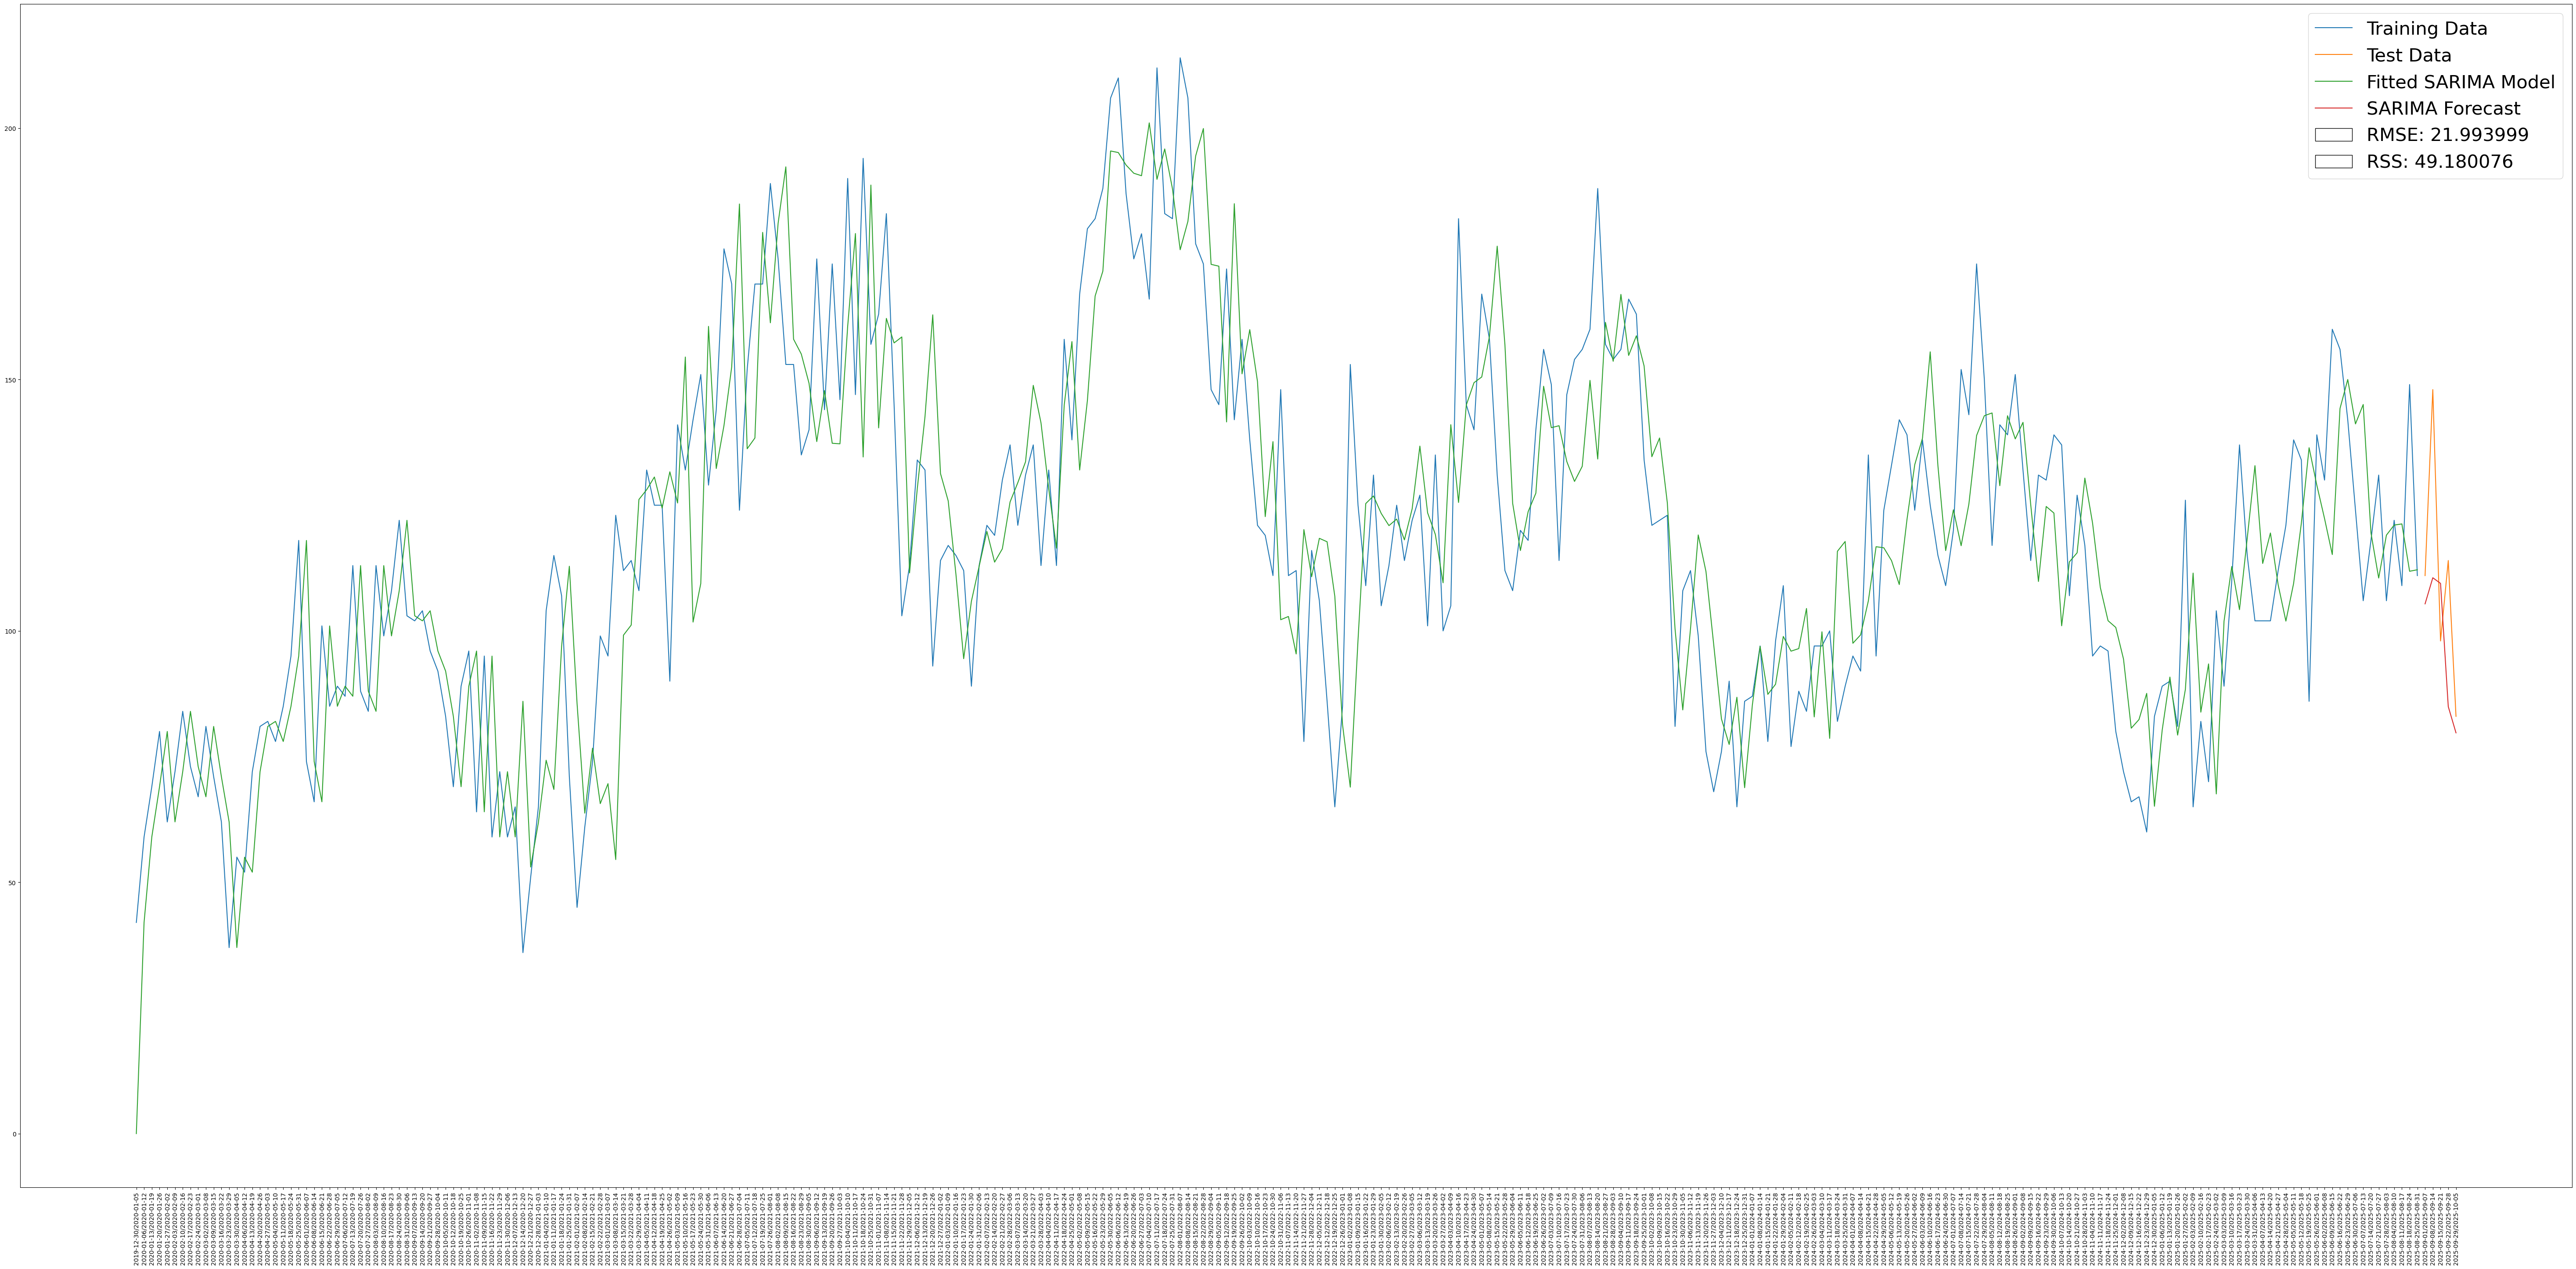

In [96]:
model = sm.ARIMA(z, order = (0, 1, 1), seasonal_order=(1,1,1,50)).fit()
print(model.summary())
plt.figure(figsize=(75,35))
plt.plot(y_train['created_date'], y_train['count'], label="Training Data")
plt.plot(y_test['created_date'], y_test['count'], label="Test Data")

plt.plot(y_train['created_date'], model.fittedvalues, label="Fitted SARIMA Model")
plt.plot(y_test['created_date'], model.forecast(len(y_test['created_date'])), label="SARIMA Forecast")


rmse = np.sqrt(np.mean((y_test['count'] - model.forecast(len(y_test['created_date'])))**2))

RMSE.append(rmse)

rss = np.sqrt(np.sum((y_test['count'] - model.forecast(len(y_test['created_date'])))**2))
text_box = Patch(facecolor='white', edgecolor='black', label=f'RMSE: {rmse:.2f}')
text_box2 = Patch(facecolor='white', edgecolor='black', label=f'RSS: {rss:.2f}')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([text_box, text_box2])
labels.extend([f"RMSE: {rmse:.6f}", f"RSS: {rss:.6f}"])
plt.tick_params(axis="x", rotation=90)

plt.legend(handles=handles, labels=labels, fontsize=30)
plt.show()

The SARIMA model fitted to the data for various cut offs (tried 2025-12-01, 2025-06-01, 2025-01-01,...) does not significantly improve on the Seasonal Moving Average Forecast at all. The RMSE actually increases by 3-5 each.

This could be because of the data we are training on since it seems the end of 2025 has a large tapering off of rat sightings which might be an anomaly!